# <center> COMP 562 : Inroduction to Machine Learning </center>
## <center> <font color='red'>Lecture 12 : Gaussian Mixture Models, EM Algorithm </font> </center> 
### <center> Mahmoud Mostapha </center> 
### <center> Department of Computer Science -- UNC Chapel Hill</center>
###  <center> October 3, 2018 </center>

 # COMP 562 – Lecture 12

Plan for today

1. EM algorithm review
2. Covariance refresher
3. Mixture of Gaussians with Covariance
4. Debugging EM algorithms

$$
\renewcommand{\xx}{\mathbf{x}}
\renewcommand{\yy}{\mathbf{y}}
\renewcommand{\zz}{\mathbf{z}}
\renewcommand{\vv}{\mathbf{v}}
\renewcommand{\bbeta}{\boldsymbol{\mathbf{\beta}}}
\renewcommand{\mmu}{\boldsymbol{\mathbf{\mu}}}
\renewcommand{\ssigma}{\boldsymbol{\mathbf{\sigma}}}
\renewcommand{\reals}{\mathbb{R}}
\renewcommand{\loglik}{\mathcal{LL}}
\renewcommand{\penloglik}{\mathcal{PLL}}
\renewcommand{\likelihood}{\mathcal{L}}
\renewcommand{\Data}{\textrm{Data}}
\renewcommand{\given}{ \big| }
\renewcommand{\MLE}{\textrm{MLE}}
\renewcommand{\EE}{\mathbb{E}}
\renewcommand{\KL}{\textrm{KL}}
\renewcommand{\Bound}{\mathcal{B}}
\renewcommand{\tth}{\textrm{th}}
\renewcommand{\Gaussian}[2]{\mathcal{N}\left(#1,#2\right)}
\renewcommand{\norm}[1]{\left\lVert#1\right\rVert}
\renewcommand{\ones}{\mathbf{1}}
\renewcommand{\diag}[1]{\textrm{diag}\left( #1 \right)}
\renewcommand{\sigmoid}[1]{\sigma\left(#1\right)}
\renewcommand{\myexp}[1]{\exp\left\{#1\right\}}
\renewcommand{\mylog}[1]{\log\left\{#1\right\}}
\renewcommand{\argmax}{\mathop{\textrm{argmax}}}
\renewcommand{\new}{\textrm{new}}
\renewcommand{\old}{\textrm{old}}
$$

# EM Algorithm for Mixture of Gaussians without Covariance

The model
$$
\begin{aligned}
p(h\mid \alpha) &= \alpha_h \\
p(\xx \mid h,\mu) &= (2\pi)^{-\frac{d}{2}} \myexp{-\frac{1}{2}(\xx - \mu_{h_t})^T(\xx - \mu_{h_t})} \\
\end{aligned}
$$
is a variant of **Mixture of Gaussians**

$\alpha_c$ is an a-priori probability that a sample comes from class $c$ -- also called **mixing proportion**

The bound 
$$
\begin{aligned}
\Bound(\Theta,q) &= \sum_{i=1}^N \sum_{h_i} q_i(h_i) \log \frac{ p(\xx_i,h_i\mid \Theta) }{ q_i(h_i) } \\
&=  \sum_{i=1}^T \sum_{h_i} q_i(h_i) \left[ \log \alpha_{h_i} -\frac{d}{2} \log (2\pi) -\frac{1}{2}(\xx - \mu_{h_i})^T(\xx - \mu_{h_i}) \right] \\
&- \sum_{i=1}^T \sum_{h_i} q_i(h_i) \log q_i(h_i)
\end{aligned}
$$
In this case $\Theta = (\alpha_1,...,\alpha_K,\mu_1, ...,\mu_K)$


# Mixture of Gaussians without Covariance -- E-step

In E-step we optimize $q$s given $\Theta$

$$
\begin{aligned}
q^{\new}_i &= \argmax_{q_i} \mathcal{B}(\Theta^{\old},q) \\
\end{aligned}
$$

In general, we can take derivatives, equate them to zero, and solve:

$$
\nabla_{q_i}  \mathcal{B}(\Theta^{\old},q)  = 0 
$$

We can show that in our case, the E-step updates are:

$$
\begin{aligned}
q_i(h_i = k) &= p(h_i =k \mid \xx_i, \mu)  = \frac{p(\xx_i,h_i = k \mid \mu)}{\underbrace{\sum_c p(\xx_i,h_i=c \mid \mu)}_{\textrm{same for all values of } k}}\\
 &\propto p(\xx_i,h_i = k\mid \mu) = p(h_i = k \mid \alpha) p(\xx \mid h_i=k,\mu) \\
        &=  \alpha_{h_i} (2\pi)^{-\frac{d}{2}} \myexp{-\frac{1}{2}(\xx - \mu_h)^T(\xx - \mu_h)}
\end{aligned}
$$ 

# Mixture of Gaussians without Covariance -- M-step

In M-step we optimize $\Theta$ given $q$s
$$
\Theta^{\new} = \argmax_{\Theta} \mathcal{B}(\Theta,q^{\new}) 
$$

In general, we can take derivatives, equate them to zero, and solve:
$$
\nabla_{\Theta}  \mathcal{B}(\Theta,q^{\new})  = 0 
$$

We can show that in our case, the M-step updates are:

$$
\begin{aligned}
\mu_k^* &= \frac{\sum_i q_i(h_i = k) \xx_i}{\sum_i q_i(h_i = k)} \\
\alpha^*_k &= \frac{\sum_i q_i(h_i = k)}{N}
\end{aligned}
$$

# Gaussian Mixture Model to Fit MNIST Dataset

In [1]:
import numpy
import matplotlib.pyplot as plt
import time
from IPython import display
%matplotlib inline

def logsumexp(vec):
    m = numpy.max(vec,axis=0)    
    return numpy.log(numpy.sum(numpy.exp(vec-m),axis=0))+m

def plot_samples_post(xs,qs,mus=None,colors=['r','g','b','k','c','m'], 
                      highlight_samples=None,
                      label_means=False):
    K,N = qs.shape
    for i in range(N):
        plt.plot(xs[0,i],xs[1,i],'o',color=qs[:,i])
    if not highlight_samples is None:
        for (i,d) in highlight_samples:
            s = ''
            for j in range(3):
                if j>0:
                    s = s + '\n'
                s = s + '$p(h_{{{}}}={} |x_{{{}}})=${:1.4f}'.format(i,j,i,qs[j,i])
            if d==0:
                plt.annotate(s,xy=(xs[0,i]+0.5,xs[1,i]-1.0),
                         bbox=dict(facecolor='white'),
                         fontsize=15)
                plt.arrow(xs[0,i]+0.5,xs[1,i],-0.5,0)
            else:
                plt.annotate(s,xy=(xs[0,i]-1,xs[1,i]-3),
                         bbox=dict(facecolor='white'),
                         fontsize=15)
                plt.arrow(xs[0,i],xs[1,i]-4.5,0,4.5)
    for c in range(K):
    # indices of samples assigned to class c
        if not mus is None:
            plt.plot(mus[0,c],mus[1,c],'kx',markersize=9,markeredgewidth=5)
            plt.plot(mus[0,c],mus[1,c],'wx',markersize=7,markeredgewidth=3)            
            if label_means:
                plt.annotate('$\mu_{}$'.format(c),xy=(mus[0,c]+0.5,mus[1,c]-0.5),
                              bbox=dict(facecolor='white'),
                              fontsize=15)

In [2]:
def mog(xs,K,iterations=10, visualize=False,delay=1):
    d,N = xs.shape
    # compute mean and std of data, and convert to
    # column vectors using numpy.newaxis trick.
    data_mean = numpy.mean(xs,axis=1)[:,numpy.newaxis]
    data_std = numpy.std(xs,axis=1)[:,numpy.newaxis]
    # initialize means around the data mean but
    # ensure they are not exactly the same by adding
    # small amount of noise
    mus = data_mean + 0.01*data_std*numpy.random.randn(d,K) 
    xs_sq = numpy.sum(xs**2.0,axis=0)
        
    logalphas = numpy.array([-numpy.log(K)]*K)
    
    logconst = -(d/2.0)*numpy.log(2.0*numpy.pi)
    logliks = []
    for it in range(iterations):
        #E-step:
        mus_sq = numpy.sum(mus**2.0,axis=0)[:,numpy.newaxis]
        mus_xs = numpy.dot(mus.transpose(),xs)
        # compute log p(x,h) for all samples
        q = logalphas[:,numpy.newaxis] + logconst - 0.5*(mus_sq - 2.0*mus_xs + xs_sq)
        
        # loglikelihood is equal to sum(logsumexp(log(p(x,h))))
        loglik = numpy.sum(logsumexp(q))
        
        logliks.append(loglik)
        # normalize columns to get log(p(h|x)) for all samples
        q = numpy.exp(q - logsumexp(q))
        
        # M-step:
        mus = numpy.dot(xs,q.transpose())/(1e-5 + numpy.sum(q,axis=1))
        logalphas = numpy.log(numpy.sum(q,axis=1)/N)
        
        if visualize:
            print "Iteration: {} Log-likelihood: {} ".format(it,loglik)
            plt.cla()            
            plot_samples_post(xs,q,mus,highlight_samples = [(121,0),(114,-1)],
                              label_means=it>0)
            plt.title(('Iteration {} Log-likelihood {} \n '+ 
                       'Red intensity = $p(h=0|x)$\n'+
                       'Green intensity = $p(h=1|x)$\n' +
                       'Blue intensity = $p(h=2|x)$').format(it,loglik),
                        multialignment='right')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(delay)

    plt.close()
    alphas = numpy.exp(logalphas)
    return mus,alphas,q,logliks

In [3]:
import os, struct
from array import array as pyarray
from numpy import append, array, int8, uint8, zeros
def load_mnist(dataset="training", digits=numpy.arange(10), path="."):
    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")
    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()
    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()
    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)
    images = zeros((N, rows, cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]
    return images, labels
images,_ = load_mnist()

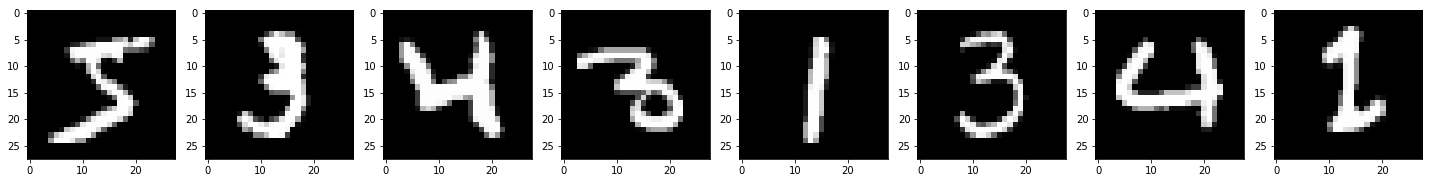

In [4]:
fig = plt.figure(figsize=(25,15))
for idx in xrange(8):
    ax = fig.add_subplot(1, 8, idx+1)
    ax.imshow(images[idx*10,:,:],interpolation='None',cmap='Greys_r')
sz = images.shape
xs_mnist = numpy.reshape(images,(sz[0],sz[1]*sz[2])).transpose()

Text(0,0.5,'Log-likelihood')

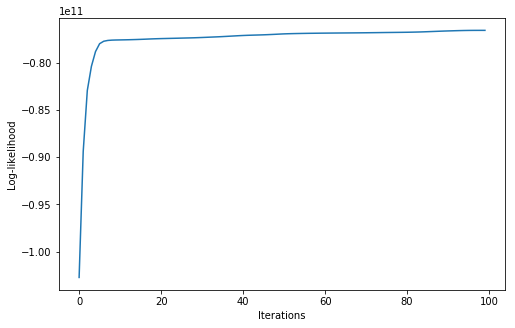

In [5]:
[mus,alphas,q,logliks] = mog(xs_mnist,10,iterations=100);
fig = plt.figure(figsize=(8, 5))
plt.plot(logliks)
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

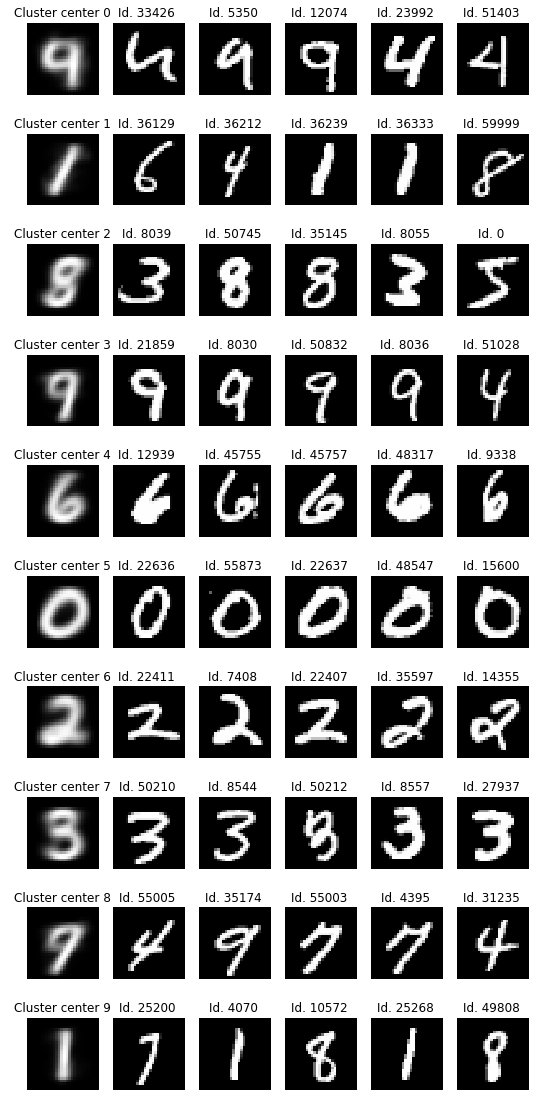

In [6]:
def show_digit(x):
    im = numpy.reshape(x,[28,28])
    plt.imshow(im,interpolation='None',cmap='Greys_r')
    plt.axis('off')
plt.figure(figsize=(9,20))
for k in range(10):    
    plt.subplot(10,6,k*6+1)
    show_digit(mus[:,k])        
    plt.title('Cluster center {}'.format(k))
    lst = numpy.argsort(q[k,:])[-5:]
    for j in range(5):
        plt.subplot(10,6,k*6+j+2)        
        show_digit(xs_mnist[:,lst[j]])
        plt.title('Id. {} '.format(lst[j]))

# Covariance Refresher

In [7]:
def generate_data(N,d,K,proby,mus,As=None):    
    if As is None:
        As = numpy.zeros((d,d,K))
        for k in range(K):
            As[:,:,k] = numpy.eye(d)
    ys = numpy.zeros(N,dtype='int')
    xs = numpy.zeros((d,N))
    for i in range(N):
        # Sample class according to the prior p(y)
        # in this case it is uniform
        ys[i] = numpy.random.choice(K,1)[0]      
        # Sample feature values according to p(x|y)
        # In this case, x ~ N(mmu[y[i]],sigma2*I)
        # To accomplish this, draw z1,z2 ~ N(0,I)    
        z = numpy.random.randn(2,1)
        # transform by matrix A and shift by class mean
        A = As[:,:,ys[i]].squeeze()
        mu = mus[:,ys[i]]
        Az = numpy.dot(A,z) 
        x = Az + mu[:,numpy.newaxis]
        xs[:,i] = x[:,0]
    return xs,ys

def plot_covariance(mu,Sigma,std_devs,color):
    N = 50
    alphas = numpy.linspace(0,2*numpy.pi,N)
    x = numpy.cos(alphas)
    y = numpy.sin(alphas)
    xy = numpy.vstack((x,y))
    d,v = numpy.linalg.eig(Sigma)
    d = numpy.sqrt(d)
    xy = std_devs*numpy.dot(numpy.dot(v,numpy.diag(d)),xy) + mu[:,numpy.newaxis]
    plt.plot(xy[0,:],xy[1,:],'w-',linewidth=6)
    plt.plot(xy[0,:],xy[1,:],color+'-',linewidth=3)
    
    
def plot_samples(xs,ys,mus=None,Sigmas=None,colors=['r','g','b','k','c','m'],labels=None):
    N = xs.shape[1]
    if not ys is None:        
        K = numpy.max(ys)+1        
        for c in range(K):
        # indices of samples assigned to class c
            ind = [i for i in range(N) if ys[i]==c]
            if labels is None:
                label = "Samples in cluster " + str(c)
            else:
                label = labels[c]
            plt.plot(xs[0,ind],xs[1,ind],colors[c]+'.',label=label)   
            if not mus is None:
                plt.plot(mus[0,c],mus[1,c],'wx',markersize=9,markeredgewidth=5)
                plt.plot(mus[0,c],mus[1,c],colors[c]+'x',markersize=7,markeredgewidth=3)
            if not Sigmas is None:
                plot_covariance(mus[:,c],Sigmas[:,:,c],2.0,colors[c])
        plt.legend(loc=2, bbox_to_anchor=(1,1))
    else:
        plt.plot(xs[0,:],xs[1,:],'.')

def plot_samples_post(xs,qs,mus=None,Sigmas=None, colors=['r','g','b','k','c','m'], 
                      highlight_samples=None,
                      label_means=False):
    K,N = qs.shape
    for i in range(N):
        plt.plot(xs[0,i],xs[1,i],'o',color=qs[:,i])
    if not highlight_samples is None:
        for (i,d) in highlight_samples:
            s = ''
            for j in range(3):
                if j>0:
                    s = s + '\n'
                s = s + '$p(h_{{{}}}={} |x_{{{}}})=${:1.4f}'.format(i,j,i,qs[j,i])
            if d==0:
                plt.annotate(s,xy=(xs[0,i]+0.5,xs[1,i]-1.0),
                         bbox=dict(facecolor='white'),
                         fontsize=15)
                plt.arrow(xs[0,i]+0.5,xs[1,i],-0.5,0)
            if d==-1:
                plt.annotate(s,xy=(xs[0,i]-2.0,xs[1,i]-4.5),
                         bbox=dict(facecolor='white'),
                         fontsize=15)
                plt.arrow(xs[0,i],xs[1,i]-4.5,0,4.5)
    for c in range(K):
    # indices of samples assigned to class c
        if not mus is None:
            plt.plot(mus[0,c],mus[1,c],'kx',markersize=9,markeredgewidth=5)
            plt.plot(mus[0,c],mus[1,c],'wx',markersize=7,markeredgewidth=3)            
            if label_means:
                plt.annotate('$\mu_{}$'.format(c),xy=(mus[0,c]+1,mus[1,c]-1),
                              bbox=dict(facecolor='white'),
                              fontsize=15)
        if not Sigmas is None:
            plot_covariance(mus[:,c],Sigmas[:,:,c],2.0,colors[c])

In [8]:
K = 3
d=2
mus = 10*numpy.asarray([[0.0,1.0,2.0],[0.0,0.0,0.0]])
As = numpy.asarray([[[2.0,0.0],[0.0,2.0]],
                    [[0.5,0.0],[0.0,5.0]],
                    [[2.0,-2.0],[0.0,2.0]]])
As = numpy.swapaxes(As,0,2)
Sigmas = numpy.zeros((d,d,K))
for c in range(K):
    A = As[:,:,c]
    Sigmas[:,:,c] = numpy.dot(A,A.transpose())
    #print "Sigma"+str(c)
    #print Sigmas[:,:,c]
proby = [1./K]*K
numpy.random.seed(1)
xs,ys = generate_data(1000,2,K,proby,mus,As)

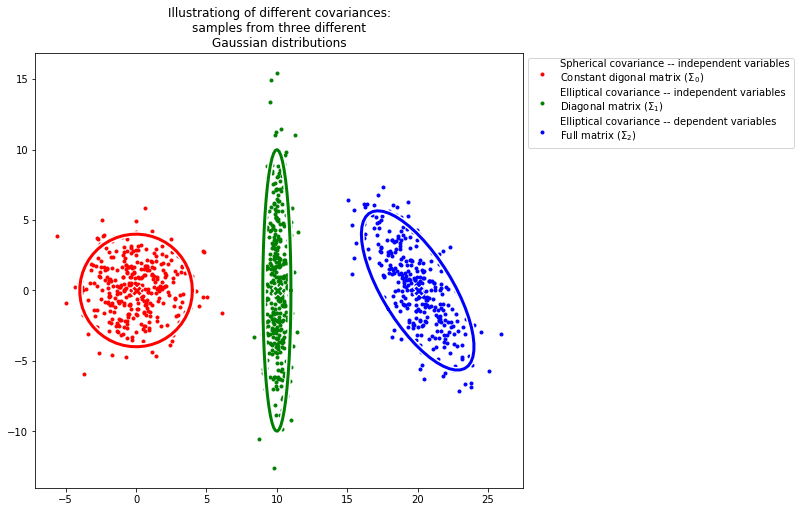

In [9]:
plt.figure(figsize=(10,8))
plot_samples(xs,ys,mus=mus,Sigmas=Sigmas,
             labels=['Spherical covariance -- independent variables\nConstant digonal matrix ($\Sigma_0$)',
                       'Elliptical covariance -- independent variables\nDiagonal matrix ($\Sigma_1$)',
                       'Elliptical covariance -- dependent variables\nFull matrix ($\Sigma_2$)'])
plt.axis('image')
plt.title('Illustrationg of different covariances:\nsamples from three different\nGaussian distributions');

# EM Algorithm for Mixture of Gaussians with Covariance

The model

$$
\begin{aligned}
p(h\mid \alpha) &= \alpha_h \\
p(\xx \mid h,\mu) &= (2\pi)^{-\frac{d}{2}}\color{red}{|\Sigma_h|^{-\frac{1}{2}}} \myexp{-\frac{1}{2}(\xx - \mu_{h_i})^T\color{red}{\Sigma_h^{-1}}(\xx - \mu_{h_i})} \\
\end{aligned}
$$

This is also a variant of **Mixture of Gaussians** Note that we introduced a covariance matrix per cluster

* Hidden variables: $h_i$ -- cluster membership for sample $i$
* Parameters: $\Theta = (\underbrace{\alpha_1,...,\alpha_K}_{\textrm{proportions}},\underbrace{\mu_1, ...,\mu_K}_{\textrm{means}},\underbrace{\Sigma_1,...,\Sigma_K}_{\textrm{covariances}})$

# EM Algorithm for Mixture of Gaussians with Covariance

We plug-in probabilities $p(\xx_i\mid h_i,\Theta)$ and $p(h_i\mid \alpha)$ in the bound

$$
\begin{aligned}
\Bound(\Theta,q) &&= \sum_{i=1}^N \sum_{h_i} q_i(h_i)&\log \frac{ p(\xx_i,h_i\mid \Theta) }{ q_i(h_i) } \\
&&=  \sum_{i=1}^N \sum_{h_i} q_i(h_i) &\left[ \log \alpha_{h_i} -\frac{d}{2} \log (2\pi)-\color{red}{\frac{1}{2}\log|\Sigma_{h_i}|}\right. \\
&&& \left.  -\frac{1}{2}(\xx_i - \mu_{h_i})^T\color{red}{\Sigma_{h_i}^{-1}}(\xx_i - \mu_{h_i}) \right] \\
&&- \sum_{i=1}^N \sum_{h_i} q_i(h_i)& \log q_i(h_i)
\end{aligned}
$$


# Mixture of Gaussians with Covariance -- E-step

$$
\begin{aligned}
q_i(h_i = k) &= p(h_i =k \mid \xx_i, \mu)  = \frac{p(\xx_i,h_i = k \mid \mu)}{\underbrace{\sum_c p(\xx_i,h_i=c \mid \mu)}_{\textrm{same for all values of } k}}\\
 &\propto p(\xx_i,h_i = k\mid \mu) = p(h_i = k \mid \alpha) p(\xx \mid h_i=k,\mu) \\\\
        &=  \alpha_{h_i} (2\pi)^{-\frac{d}{2}}\color{red}{|\Sigma_{h_i}^{-1}|} \myexp{-\frac{1}{2}(\xx - \mu_{h_i})^T\color{red}{\Sigma_{h_i}^{-1}}(\xx - \mu_{h_i})}
\end{aligned}
$$ 
Implementation:
```
q = numpy.zeros((K,N))           # clusters x samples
q = logjointp(x,Theta)           # compute all joints at once
loglik = numpy.sum(logsumexp(q)) # compute loglikelihood
q = q - logsumexp(q)             # normalizing across clusters
```


# Mixture of Gaussians with Covariance -- M-step

Updates for parameters of prior probability $p(h \mid \alpha)$
$$
\alpha^*_k = \frac{\sum_i q_i(h_i = k)}{N}
$$
Updates for means of clusters
$$
\mu_k^* = \frac{\sum_i q_i(h_i = k) \xx_i}{\sum_i q_i(h_i = k)} 
$$
Updates for covariances of clusters
$$
\Sigma_k^* = \frac{\sum_i q_i(h_i = k) (\xx_i - \mu^*_k)(\xx_i-\mu^*_k)^T}{\sum_i q_i(h_i = k)} 
$$

In [10]:
def logjointp(xs,mus,Sigmas,logph = None):    
    # compute log p(x,h|mus,Sigmas)
    # for all values of h (1..K)    
    d = xs.shape[0]
    N = xs.shape[1]
    K = mus.shape[1]    
    # dimensions are consistent
    assert(mus.shape[0] == d and 
           Sigmas.shape[0] == d and
           Sigmas.shape[1] == d and
           Sigmas.shape[2] == K)
    if logph is None:
        # no prior for clusters provided
        # assume uniform probability
        logph = numpy.asarray([1./K]*K)
        
    logp = numpy.zeros( (K,N) )
    for k in range(K):
        # get the covaraiance and squeeze
        # the last dimension to get d x d matrix
        Sigma = Sigmas[:,:,k].squeeze()        
        mu = mus[:,k]
        invSigma = numpy.linalg.inv(Sigma)
        ###
        # For each sample we need to compute: 
        #    (x - mu) Sigma^{-1} (x - mu)
        # We will do this at once for all samples
        #        
        # (x-mu)^T  for all rows of matrix xs
        # mu[:,numpy.newaxis] turns row vector into a column
        res = xs - mu [:,numpy.newaxis]
        # (x-mu)^T Sigma^{-1} for all rows of matrix X
        res_T_invSigma = numpy.dot(res.transpose(),invSigma)              
        # need to compute inner product between 
        # *corresponding* rows of ((x-mu)^T Sigma^{-1}) and (x-mu)
        res_T_invSigma_res = numpy.sum(res_T_invSigma.transpose()*res,axis=0)        
        logp[k,:] = -0.5*res_T_invSigma_res
        logp[k,:] = logp[k,:] - d/2.*numpy.log(2.*numpy.pi)
        logp[k,:] = logp[k,:] - 0.5*numpy.log(numpy.linalg.det(Sigma))
        logp[k,:] = logp[k,:] + logph[k]
    return logp
                            

In [11]:
def logsumexp(vec):
    m = numpy.max(vec,axis=0)    
    return numpy.log(numpy.sum(numpy.exp(vec-m),axis=0))+m

def mog_c(xs,K,iterations=10, visualize=False,delay=1):
    d,N = xs.shape
    # compute mean and std of data    
    data_mean = numpy.mean(xs,axis=1)
    data_std = numpy.std(xs,axis=1)
    # initialize means around the data mean but
    # ensure they are not exactly the same by adding
    # small amount of noise
    mus = (data_mean[:,numpy.newaxis] + 
          0.1*data_std[:,numpy.newaxis]*numpy.random.randn(d,K))
    Sigmas = numpy.zeros((d,d,K))
    for k in range(K):
        # start with large covariance
        Sigmas[:,:,k] = 0.1*numpy.eye(d) + 10.*numpy.diag(data_std)
        

    # assume uniform prior 
    logph = numpy.array([-numpy.log(K)]*K)

    logliks = []
    for it in range(iterations):
        # E-step
        q = logjointp(xs,mus,Sigmas,logph)
        assert(q.shape[0] == K)
        loglik = numpy.sum(logsumexp(q))
        logliks.append(loglik)        
        q = numpy.exp(q - logsumexp(q))
        
        # M-step:        
        mus = numpy.dot(xs,q.transpose())/(1e-5 + numpy.sum(q,axis=1))
        logph = numpy.log(numpy.sum(q,axis=1)/N)
        for k in range(K):
            mu = mus[:,k]
            res = xs - mu[:,numpy.newaxis]
            Sigma = numpy.dot(q[k,:]*res,res.transpose())/numpy.sum(q[k,:])
            Sigmas[:,:,k] = Sigma
  
        if visualize and it % 10 == 0:
            print "Iteration: {} Log-likelihood: {} ".format(it,loglik)
            plt.cla()   
            plot_samples_post(xs,q,mus,Sigmas,label_means=it>0)
            plt.title(('Iteration {} Log-likelihood {} \n '+ 
                       'Red intensity = $p(h=0|x)$\n'+
                       'Green intensity = $p(h=1|x)$\n' +
                       'Blue intensity = $p(h=2|x)$').format(it,loglik),
                        multialignment='right')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(delay)
            
    plt.close()
    alphas = numpy.exp(logph)
    return mus,alphas,q,Sigmas,logliks

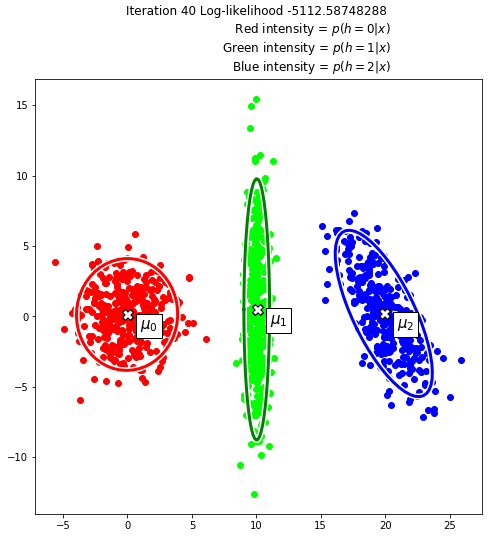

In [12]:
fig = plt.figure(figsize=(8, 8))
[mus,alphas,q,Sigmas,logliks] = mog_c(xs,3,iterations=50,visualize=True,delay=1);

Text(0,0.5,'Log-likelihood')

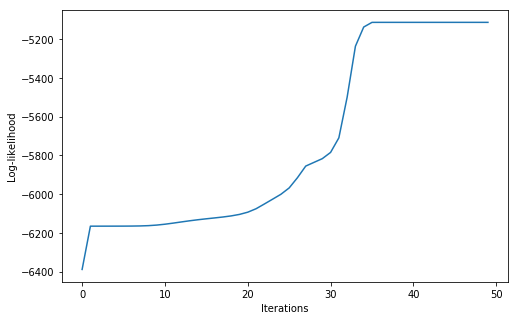

In [13]:
fig = plt.figure(figsize=(8, 5))
plt.plot(logliks)
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

# Debugging EM Algorithm

1. Log-likelihood should always go up!
2. Synthetic data is your friend, if you generate data from your model you get samples and cluster membership
3. E-step computes cluster membership based on parameters. Use this!
    * Synthesize data from ground truth parameters 
    * Start your EM from ground truth parameters, not random initialization
    * Does your E step associate samples with correct clusters?
    * Select one sample and look at its posterior probability for the cluster it came from
4. M-step updates parameters based on cluster membership. Use this!
    * Using synthetic data, set ```q``` to be one-hot according to ground truth
    * Start your M-step with this ```q```
    * If you don't get parameters back that are close to the ground truth
    * To isolate a broken update, let M-step update just one parameter (for example mus)
5. Starting your EM with ground truth parameters should not budge too much
    
Between these tricks you should be able to isolate source of your problem

# Today

* Mixture of Gaussian with Covariances
* Details of update derivation for means, covariances
* Debugging EM algorithm